In [1]:
import sqlite3
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from stop_words import get_stop_words
from tqdm import tqdm_notebook as tqdm
import gensim
from gensim import corpora, models, similarities
from gensim.models.doc2vec import TaggedDocument,TaggedLineDocument
from gensim.models import Doc2Vec
import gensim.models.doc2vec
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
from collections import OrderedDict
import multiprocessing
from collections import defaultdict
from nltk.tokenize.moses import MosesDetokenizer
from IPython.display import Image
import requests
from random import randint 
from sklearn.manifold import TSNE
from sklearn.cluster import AffinityPropagation
import matplotlib.pyplot as plt
%matplotlib inline

# PLOS Capstone Progress Update 
### 2/6/18

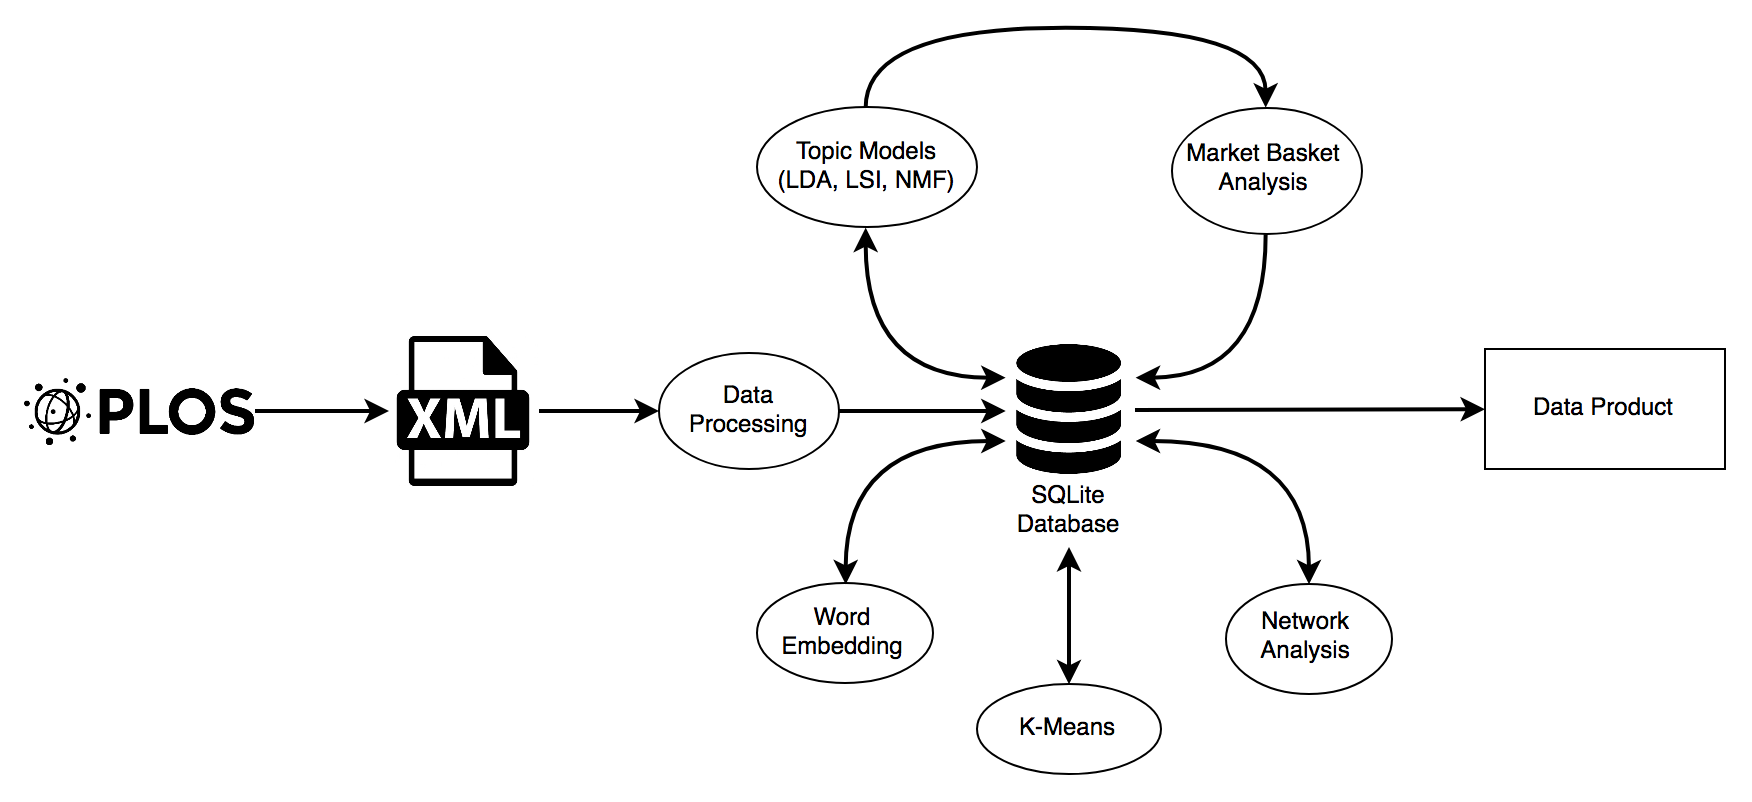

In [2]:
Image('dataflow.png')

## Data Loading

In [2]:
# Establish db connection, load data
conn = sqlite3.connect("/Users/jackprominski/Desktop/UVA DSI/Capstone/testDB.db")
df = pd.read_sql_query("select doi,title,abstract,body from trial_10000;", conn)
df['abstract']=df['abstract'].str.replace('\d+', '') # for digits
df['abstract']=df['abstract'].str.replace(r'(\b\w{1,2}\b)', '') # for words
df['abstract']=df['abstract'].str.replace('Background', '')
df['body']=df['body'].str.replace('Introduction', '')
df['title']=df['title'].str.strip("[]'")

In [16]:
df.head()

,doi,title,abstract,body
0,10.1371/journal.pone.0000100,Factors Affecting Frequency Discrimination of ...,Measuring perceptual judgments about stimuli w...,Many investigations of sensory processing are ...
1,10.1371/journal.pone.0000008,Molecular Adaptation during Adaptive Radiation...,“Explosive” adaptive radiations islands remai...,The most dramatic “bursts” of adaptive radiati...
2,10.1371/journal.pone.0000061,Self-Correcting Maps of Molecular Pathways,Reliable and comprehensive maps molecular pat...,Scientific innovation often proceeds through a...
3,10.1371/journal.pone.0000094,A Bayesian Network Driven Approach to Model th...,The transcriptional response exogenously supp...,Nitric oxide (NO·) is a critical mediator of t...
4,10.1371/journal.pone.0000011,A Comparative Study on the Cost of New Antibio...,Drug treatment becoming more expensive due t...,The investment of societies around the world o...


In [3]:
# Load saved model files
lsi = models.LsiModel.load('models/model.lsi')
lda = models.LdaModel.load('models/model.lda')
tfidf = models.TfidfModel.load('models/model.tfidf')
index = similarities.MatrixSimilarity.load('models/similarity.index')
corpus = corpora.MmCorpus('models/corpus.mm')
dictionary = corpora.Dictionary.load('models/dictionary.dict')

In [4]:
# Transform corpus
corpus_tfidf = tfidf[corpus]
corpus_lsi = lsi[corpus_tfidf]
corpus_lda = lda[corpus_tfidf]

## Topic Modeling

Topic modeling is a technique for the discovery of hidden (or "latent") semantic structures in a corpus. Each document is described in terms of one or more "topics," which are made up of the most common words in that topic. These unobserved semantic relationships can be used to ascertain similarity between documents. Topic weights can also be used as inputs for other analysis methods, like association rule learning.

In [10]:
print('LSI Topics')
print()
for i in range(0,6):
    x = randint(0,200)
    print('Topic ' + str(x) + ': ' + lsi.print_topic(x))
    print()

print('---------')
print()
print('LDA Topics')
print()
for i in range(0,6):
    x = randint(0,200)
    print('Topic ' + str(x) + ': ' + lda.print_topic(x))
    print()

LSI Topics

Topic 88: 0.236*"bone" + -0.222*"tlr" + 0.184*"may" + 0.180*"identifi" + 0.164*"process" + -0.160*"high" + 0.156*"individu" + 0.151*"posit" + -0.147*"two" + -0.145*"predict"

Topic 172: 0.272*"includ" + 0.152*"splice" + -0.145*"sensit" + 0.136*"visual" + -0.125*"day" + -0.122*"howev" + -0.112*"variat" + 0.109*"local" + -0.107*"inform" + -0.105*"myc"

Topic 103: 0.245*"tlr" + -0.198*"process" + 0.196*"predict" + 0.190*"gener" + 0.171*"analysi" + 0.165*"complex" + -0.155*"channel" + 0.150*"mitochondri" + -0.148*"treatment" + -0.142*"methyl"

Topic 186: -0.173*"import" + -0.167*"day" + -0.156*"replic" + -0.140*"myc" + 0.136*"anim" + -0.127*"size" + -0.120*"phenotyp" + -0.119*"vivo" + -0.119*"involv" + -0.116*"macrophag"

Topic 114: -0.249*"non" + -0.202*"also" + 0.184*"mechan" + -0.181*"drug" + -0.176*"bone" + -0.172*"promot" + -0.162*"process" + 0.139*"can" + 0.135*"treatment" + -0.133*"sleep"

Topic 7: -0.441*"activ" + 0.382*"express" + 0.258*"mice" + -0.244*"hiv" + 0.223*"v

In [14]:
# Get a DOI
x = randint(0,200)
df.loc[x]['doi']

'10.1371/journal.pone.0000115'

In [60]:
## SHOW TOPIC WEIGHTS OF A GIVEN DOCUMENT

doi_in = input('Enter a DOI: ')
qu_doi = df.loc[df['doi']==doi_in].index[0]
print('Title:')
print(df.loc[qu_doi]['title'])
print()
topics = lda.get_document_topics(corpus[qu_doi],minimum_probability=.05)
print('Topic Weights:')
print(sorted(topics,key=lambda x: x[1],reverse=True))
print()
for i in range(3):
    print('Topic ' + str(topics[i][0]) + ': ')
    [print(x[0]) for x in lda.show_topic(topics[i][0])]
    print()


Enter a DOI: 10.1371/journal.pone.0000020
Title:
Societal Learning in Epidemics: Intervention Effectiveness during the 2003 SARS Outbreak in Singapore

Topic Weights:
[(74, 0.2701141), (171, 0.110299125), (176, 0.10901061), (97, 0.08740212), (76, 0.06643704)]

Topic 74: 
influenza
season
temperatur
pandem
diseas
epidem
malaria
outbreak
mortal
use

Topic 76: 
cost
durat
life
potenc
longer
effect
shorter
cation
conjunct
expect

Topic 97: 
motor
learn
languag
odor
control
olfactori
skill
tail
acc
associ



In [19]:
# Search treats the query as another document -- which links it to topics and the hidden semantic
# structures of the text. Then returns similarly topic weighted results. 

doc = input('Enter a search query: ')

vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lsi = lsi[vec_bow] # convert the query to LSI space
lsi_sims = sorted(enumerate(index[vec_lsi]), key=lambda item: -item[1])
simdocs_lsi = [x[0] for x in lsi_sims[0:10]]

for i in range(0,len(simdocs_lsi)):
    print(str(i+1) + '. ' + df.loc[simdocs_lsi[i],'title'])

Enter a search query: HIV
1. Regional Differences in Prevalence of HIV-1 Discordance in Africa and Enrollment of HIV-1 Discordant Couples into an HIV-1 Prevention Trial
2. Characteristics of HIV-1 Discordant Couples Enrolled in a Trial of HSV-2 Suppression to Reduce HIV-1 Transmission: The Partners Study
3. Late HIV Diagnosis and Determinants of Progression to AIDS or Death after HIV Diagnosis among Injection Drug Users, 33 US States, 1996–2004
4. Genital Herpes Has Played a More Important Role than Any Other Sexually Transmitted Infection in Driving HIV Prevalence in Africa
5. Empirical Evidence for Synchrony in the Evolution of TB Cases and HIV+ Contacts among the San Francisco Homeless
6. HIV Aspartyl Peptidase Inhibitors Interfere with Cellular Proliferation, Ultrastructure and Macrophage Infection of 
7. Vaccinia Scars Associated with Improved Survival among Adults in Rural Guinea-Bissau
8. HIV Transmission in a State Prison System, 1988–2005
9. HCV Coinfection Associated with Slo

In [17]:
# Most similar documents given doi
query_doi = input('Enter a DOI: ')
query_doc = df.loc[df['doi']==query_doi].index[0]
doc_bow = corpus[query_doc]

vec_lsi = lsi[doc_bow]
lsi_sims = sorted(enumerate(index[vec_lsi]), key=lambda item: -item[1])
simdocs_lsi = [x[0] for x in lsi_sims[1:11]]

vec_lda = lda[doc_bow]
lda_sims = sorted(enumerate(index[vec_lda]), key=lambda item: -item[1])
simdocs_lda = [x[0] for x in lda_sims[0:10]]

print('Target: ' + df.loc[query_doc,'title'])
print('LSI Most Similar Documents:')
for i in range(0,len(simdocs_lsi)):
    print(str(i+1) + '. ' + df.loc[simdocs_lsi[i],'title'])


Enter a DOI: 10.1371/journal.pone.0000094
Target: A Bayesian Network Driven Approach to Model the Transcriptional Response to Nitric Oxide in 
LSI Most Similar Documents:
1. How to Turn a Genetic Circuit into a Synthetic Tunable Oscillator, or a Bistable Switch
2. Computational Modelling of Genome-Side Transcription Assembly Networks Using a Fluidics Analogy
3. Network ‘Small-World-Ness’: A Quantitative Method for Determining Canonical Network Equivalence
4. The Role of Input Noise in Transcriptional Regulation
5. Comparing Artificial Neural Networks, General Linear Models and Support Vector Machines in Building Predictive Models for Small Interfering RNAs
6. Floral Morphogenesis: Stochastic Explorations of a Gene Network Epigenetic Landscape
7. Boolean Network Model Predicts Cell Cycle Sequence of Fission Yeast
8. Statecharts for Gene Network Modeling
9. Non-Uniform Survival Rate of Heterodimerization Links in the Evolution of the Yeast Protein-Protein Interaction Network
10. Optimal 

## Word Embedding

Word Embedding is a neural network model to represent words and documents as numerical vectors. The goal is to learn word representations that can predict a document given its surrounding words and documents. This allows context to play a much larger role in document grouping, and thus give better querying results.

In [70]:
documents = [doc for doc in TaggedLineDocument('processed_docs.txt')]
model = Doc2Vec(documents, size=200, window=5, min_count=5,workers=7)
np.save('models/features-w2v-200.npy',model.docvecs.doctag_syn0)
model.save('models/features-w2v-200.doc2vec')

In [5]:
model = Doc2Vec.load('models/features-w2v-200.doc2vec')

In [13]:
doc_id = np.random.randint(model.docvecs.count) 
sims = model.docvecs.most_similar(doc_id, topn=model.docvecs.count)  # get *all* similar documents
print(u'TARGET (%d): «%s»' % (doc_id, ''.join(df.loc[doc_id]['title'])))
print(df.loc[sims[0][0]]['doi'])
print()

for label, index in [('MOST', 0), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»' % (label, sims[index], ''.join(df.loc[sims[index][0]]['title'])))
    print(df.loc[sims[index][0]]['doi'])
    print()

TARGET (6251): «"Mental Rotation of Faces in Healthy Aging and Alzheimer's Disease"»
10.1371/journal.pone.0006460

MOST (6588, 0.9276092052459717): «The Composite Task Reveals Stronger Holistic Processing in Children than Adults for Child Faces»
10.1371/journal.pone.0006460

LEAST (7128, -0.7308048009872437): «High Efficiency Lipid-Based siRNA Transfection of Adipocytes in Suspension»
10.1371/journal.pone.0006940

